In [2]:
# импорт необходимых библиотек:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression

### 1. Знакомство и предобработка.

In [3]:
data = pd.read_csv('CrabAgePrediction.csv', sep=',')    # загружаем датасет

In [4]:
data.info()    # посмотрим основную информацию по данным

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          3893 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3893 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


Все типы данных соответсвуют необходимым и пропуски отсутсвуют. Проверим данные на наличие дубликатов.

In [5]:
data.duplicated().sum()    # дубликатов не найдено

0

Для удобства хочется обработать названия столбцов.

In [6]:
col = ['_'.join(i.lower().split()) for i in list(data.columns)]

In [7]:
data.columns = col

In [8]:
data.head()

,sex,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


Посмотрим, есть ли аномальные значения и выбросы в данных.

In [9]:
data['sex'].unique()

array(['F', 'M', 'I'], dtype=object)

F - жен

M - муж

I - не определено

Можно будет ввести две фиктивные переменные в модель.

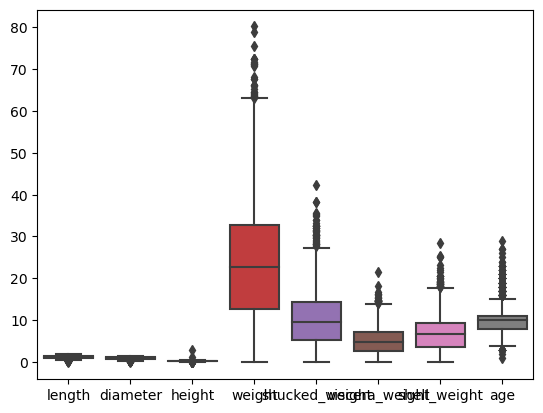

In [10]:
sns.boxplot(data=data[col[1:]])
plt.show()

Выбросы есть, значений меньше нуля, которых не должно быть нет. Почистим выбросы по межквартильному размаху.

In [11]:
for c in col[1:]:
    q3 = data[c].describe()['75%']    # 75-ая квантиль
    q1 = data[c].describe()['25%']    # 25-ая квантиль
    iqr = q3-q1    # длина промежутка
    iqr_min = q1 - 1.5 * iqr    # нижняя граница
    iqr_max = q3 + 1.5 * iqr    # верхняя граница
    data = data[(iqr_min <= data[c]) & (data[c] <= iqr_max)]    # перезаписываем датасет без выбросов

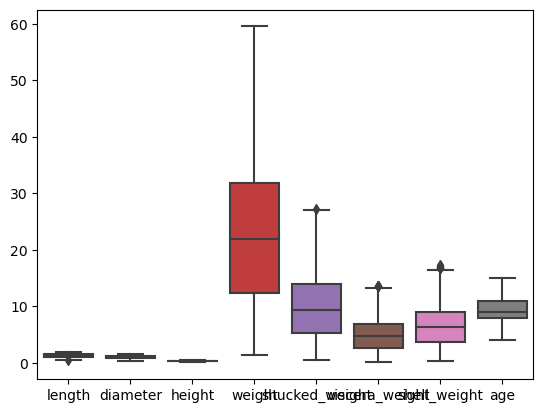

In [12]:
sns.boxplot(data=data[col[1:]])
plt.show()

Стандартизируем количественные переменные.

### 2. Стандартизация.

In [13]:
x_c = np.array(data[col[1:-1]].copy())
y = np.array(data['age'].copy())

In [14]:
# разделим выборку на тестовую и тренировочную:
x_train, x_test, y_train, y_test = train_test_split(x_c, y, test_size=0.2, random_state=50)

In [15]:
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.fit_transform(x_test)

In [16]:
f = col.copy()
del f[0]
del f[-1]

### 3. Отбор факторов.

In [17]:
data.corr()['age']

length            0.582776
diameter          0.601205
height            0.610596
weight            0.555977
shucked_weight    0.463742
viscera_weight    0.541703
shell_weight      0.619616
age               1.000000
Name: age, dtype: float64

Связь возраста со всеми параметрами, кроме пола, заметная. Для отбора факторов попробуем использовать пермутационную важность и значения коэффициента Шепли, думаю всё дело в стандартизации переменных. Отбор будет производиться по количественным переменным, а фиктивные переменные будут добавлены позже, чтобы проверить улучшают ли они модель.

In [18]:
import shap

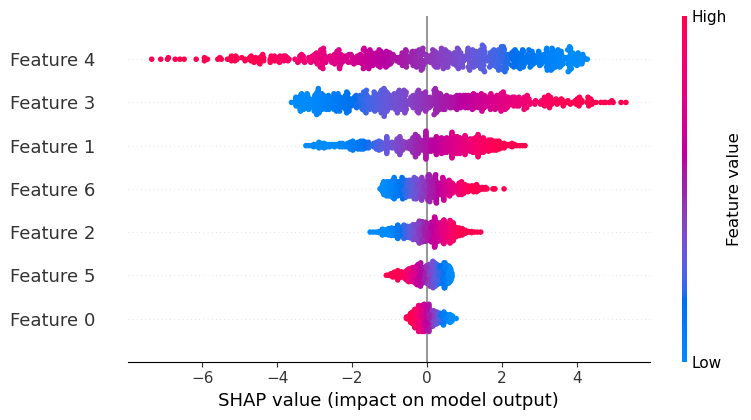

In [19]:
model = LinearRegression()
model.fit(x_train_st, y_train)

explainer = shap.Explainer(model, x_train_st)
shap_values = explainer(x_test_st)

shap.summary_plot(shap_values, x_test_st)

In [20]:
import eli5
from eli5.sklearn import PermutationImportance

In [21]:
perm = PermutationImportance(model, random_state=40).fit(x_test_st, y_test)
eli5.show_weights(perm, feature_names=f)

Weight,Feature
2.5818 ± 0.1695,shucked_weight
1.5639 ± 0.1322,weight
0.5682 ± 0.1030,diameter
0.1730 ± 0.0213,shell_weight
0.0980 ± 0.0135,height
0.0671 ± 0.0088,viscera_weight
0.0278 ± 0.0214,length


Результаты совпали. Будем строить линейную модель и постепенно добавлять в нее переменные по убыванию пермутационной важности. Странно, что у фактора "shucked weight" самый низкий показатель коэффициента корреляцци, а влияние по Шепли и пермутационной важности на результат наибольшее.

### 4. Моделирование.

In [22]:
from sklearn.metrics import r2_score

In [23]:
a = [4, 3, 1, 6, 2, 5, 0]
r_2 = {}

In [24]:
for i in range(len(a)):
    x_tr = x_train_st[:, a[:i+1]]
    x_t = x_test_st[:, a[:i+1]]
    if i == 0:
        x_tr = x_tr.reshape(x_train_st.shape[0], 1)
        x_t = x_t.reshape(x_test_st.shape[0], 1)
    model = LinearRegression().fit(x_tr, y_train)
    prediction = model.predict(x_t)
    r = r2_score(y_test, prediction)
    r_2[a[i]] = r

In [25]:
r_2

{4: 0.17841681354513061,
 3: 0.4112555463325228,
 1: 0.45292597447017535,
 6: 0.4659739377446661,
 2: 0.47983547836902785,
 5: 0.4758050216501998,
 0: 0.47522090352214996}

Итак, при включении в модель по порядку факторов сначала коэффициент детерминации увеличивается, а потом начинает снижаться. Пока наилучшей оделью явялется модель, включающая в качестве факторов:
1. shucked weight - вес оставшийся
2. weight - вес (общий)
3. diameter - диаметр
4. shell weight - масса панциря
5. height - высота

Посмотрим, какие результаты дадут модели, включающие только по одному фактору.

In [26]:
for i in range(len(a)):
    x_tr = x_train_st[:, a[i]]
    x_t = x_test_st[:, a[i]]
    x_tr = x_tr.reshape(x_train_st.shape[0], 1)
    x_t = x_t.reshape(x_test_st.shape[0], 1)
    model = LinearRegression().fit(x_tr, y_train)
    prediction = model.predict(x_t)
    r = r2_score(y_test, prediction)
    r_2[f[a[i]]] = r

In [27]:
r_2

{4: 0.17841681354513061,
 3: 0.4112555463325228,
 1: 0.45292597447017535,
 6: 0.4659739377446661,
 2: 0.47983547836902785,
 5: 0.4758050216501998,
 0: 0.47522090352214996,
 'shucked_weight': 0.17841681354513061,
 'weight': 0.2780497428325035,
 'diameter': 0.3289285974603474,
 'shell_weight': 0.3574382782893334,
 'height': 0.3570669502006606,
 'viscera_weight': 0.28380809190324774,
 'length': 0.3156234829142842}

Тут результаты уже ниже, поэтому данные модели нам не нужны, так как целью является построение моедли, которая наилучшим образом описывает результат.

Что если попробовать все возможные комбинации факторов?

In [28]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(list(combinations(s, r)) for r in range(len(s)+1))

In [29]:
s = list(powerset(a))

In [30]:
for i in range(1, len(s)):
    j = list(s[i])
    if j == a[:len(j)]:
        continue
    x_tr = x_train_st[:, j]
    x_t = x_test_st[:, j]
    if len(j) == 1:
        x_tr = x_tr.reshape(x_train_st.shape[0], 1)
        x_t = x_t.reshape(x_test_st.shape[0], 1)
    model = LinearRegression().fit(x_tr, y_train)
    prediction = model.predict(x_t)
    r = r2_score(y_test, prediction)
    r_2[f'{i}'] = r

In [31]:
sorted(r_2.items(), key=lambda x:x[1], reverse=True)[0]

(2, 0.47983547836902785)

Наилучшая модель не изменилась.

### 5. Модели с фиктивными переменными.

Попробуем улучшить наилучшую модель, полученную выше, при помощи введения фиктивных переменных (пол). Будет введено две фиктивных переменных, так как уникальных значений пола в датасете три.

In [32]:
f = [4, 3, 1, 6, 2]

а) Модель с фиктивными переменными сдвига:

In [33]:
data['F'] = data['sex'].map({'F': 1, 'M': 0, 'I': 0})
data['M'] = data['sex'].map({'F': 0, 'M': 1, 'I': 0})

x_f = np.array(data[['F', 'M']].copy())
x_f_train, x_f_test, y_train, y_test = train_test_split(x_f, y, test_size=0.2, random_state=50)

xx = x_c[:, f]
x_train, x_test, y_train, y_test = train_test_split(xx, y, test_size=0.2, random_state=50)
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.fit_transform(x_test)

x_train = np.concatenate((x_train_st, x_f_train), axis=1)
x_test = np.concatenate((x_test_st, x_f_test), axis=1)

In [34]:
model = LinearRegression().fit(x_train, y_train)
prediction = model.predict(x_test)
r = r2_score(y_test, prediction)
r_2['сдвиг'] = r

In [35]:
r > r_2[2]

True

Уровень объясненности модели повысился.

In [36]:
r

0.5093099774932068

b) Модель с фиктивными переменными наклона:

In [37]:
df = data[['shucked_weight', 'weight', 'shell_weight', 'height', 'length', 'F', 'M', 'age']].copy()

In [38]:
for c in list(df.columns)[:-3]:
    df[f'{c}*F'] = df[c] * df['F']
    df[f'{c}*M'] = df[c] * df['M']

In [39]:
xx = x_c[:, f]
x_train, x_test, y_train, y_test = train_test_split(xx, y, test_size=0.2, random_state=50)
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.fit_transform(x_test)

x_f = np.array(df[df.columns[8:]].copy())
x_f_train, x_f_test, y_train, y_test = train_test_split(x_f, y, test_size=0.2, random_state=50)

x_train = np.concatenate((x_train_st, x_f_train), axis=1)
x_test = np.concatenate((x_test_st, x_f_test), axis=1)

In [40]:
model = LinearRegression().fit(x_train, y_train)
prediction = model.predict(x_test)
r = r2_score(y_test, prediction)
r_2['наклон'] = r

In [41]:
r_2['наклон'] > r_2['сдвиг']

True

In [42]:
r

0.5259308374952363

Модель еще улучшилась.

с) Модель с фиктивными переменными в общем виде:

In [43]:
xx = x_c[:, f]
x_train, x_test, y_train, y_test = train_test_split(xx, y, test_size=0.2, random_state=50)
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.fit_transform(x_test)

x_f = np.array(df[['F', 'M']].copy())
x_f = np.concatenate((x_f, np.array(df[df.columns[8:]].copy())), axis=1)
x_f_train, x_f_test, y_train, y_test = train_test_split(x_f, y, test_size=0.2, random_state=50)

x_train = np.concatenate((x_train_st, x_f_train), axis=1)
x_test = np.concatenate((x_test_st, x_f_test), axis=1)

In [44]:
model = LinearRegression().fit(x_train, y_train)
prediction = model.predict(x_test)
r = r2_score(y_test, prediction)
r_2['общий'] = r

In [45]:
r_2['общий'] > r_2['наклон']

True

In [46]:
r_2['общий']

0.5349795110406586

На данный момент лучшей является модель линейной регрессии с фиктивными перемынными в общем виде, которая выглядит следубщим образом:

y = b0 + b1\*x1 + ... + bn\*xn + c1\*z1 + ... + cm\*zm + d11\*x1\*z1 + ... + d1n\*xn\*z1 + d21\*x1\*z2 + ... + dmn\*xn\*zm + E

### 6. PCA.

In [47]:
from sklearn.decomposition import PCA

In [48]:
r = []
for i in range(1, len(f)):
    x_train, x_test, y_train, y_test = train_test_split(x_c[:, f], y, test_size=0.2, random_state=50)
    scaler = StandardScaler()
    x_train_st = scaler.fit_transform(x_train)
    x_test_st = scaler.fit_transform(x_test)
    
    pca = PCA(n_components=i, whiten=True)
    pca = pca.fit(x_train_st)
    x_train = pca.transform(x_train_st)
    x_test = pca.transform(x_test_st)
    
    model = LinearRegression()
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    r.append(r2_score(y_test, prediction))

In [49]:
r

[0.3174145870339333,
 0.4158266121115868,
 0.4672503022583251,
 0.46972147204048154]

In [50]:
r = {}
for i in range(1, 7):
    x_train, x_test, y_train, y_test = train_test_split(x_c[:, a], y, test_size=0.2, random_state=50)
    
    pca = PCA(n_components=i, whiten=True)
    pca = pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)
    
    model = LinearRegression()
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    r[i] = r2_score(y_test, prediction)

In [51]:
r

{1: 0.26939721390945925,
 2: 0.4434240068715317,
 3: 0.4413535681544565,
 4: 0.44093921065398634,
 5: 0.46318613270378906,
 6: 0.47768812290066986}

### 7. Нелинейные модели.

Гипербола

In [52]:
(x_c == 0).sum()

0

In [53]:
hip_model = LinearRegression()
x_hip = 1 / x_c    # независимые переменные
# зависимая переменная остается такой же
x_train, x_test, y_train, y_test = train_test_split(x_hip, y, test_size=0.2, random_state=40)
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.fit_transform(x_test)

hip_model.fit(x_train_st, y_train)
y_pred = hip_model.predict(x_test_st)
r2_hip = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2_hip)

Коэффициент детерминации (R^2): 0.45248533084225606


Полулогарифмическая

In [54]:
(x_c <= 0).sum()

0

In [55]:
log_model = LinearRegression()
x = np.log(x_c)    # независимые переменные
# зависимая переменная остается такой же
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.fit_transform(x_test)

log_model.fit(x_train_st, y_train)
y_pred = log_model.predict(x_test_st)
r2 = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2)

Коэффициент детерминации (R^2): 0.41811709998482305


Парабола

In [56]:
x_p = x_c ** 2
x_par = np.array(np.concatenate((x_c, x_p), axis=1)) # независимые переменные
for i in range(7):
    for j in range(i+1, 7):
        x_par = np.array(np.concatenate((x_par, (x_c[:, i] * x_c[:, j]).reshape(3522, 1)), axis=1))
par_model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(x_par, y, test_size=0.2, random_state=40)
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.fit_transform(x_test)

par_model.fit(x_train_st, y_train)
y_pred = par_model.predict(x_test_st)
r2_par = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2_par)

Коэффициент детерминации (R^2): 0.5348591395682669


Показательная

In [57]:
(y <= 0).sum()

0

In [58]:
pok_model = LinearRegression()
y_pok = np.log(y)    # зависимая переменная
x_train, x_test, y_train, y_test = train_test_split(x_c, y_pok, test_size=0.33, random_state=42)
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.fit_transform(x_test)

pok_model.fit(x_train_st, y_train)
y_pred = pok_model.predict(x_test_st)
r2 = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2)

Коэффициент детерминации (R^2): 0.49965581117590374


Степенная

In [59]:
st_model = LinearRegression()
x_st = np.log(x_c)    # независимые переменные
y_st = np.log(y)    # зависимая переменная
x_train, x_test, y_train, y_test = train_test_split(x_st, y_st, test_size=0.33, random_state=42)
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.fit_transform(x_test)

st_model.fit(x_train_st, y_train)
y_pred = st_model.predict(x_test_st)
r2 = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2)

Коэффициент детерминации (R^2): 0.49772162926424623


Параболическая модель показала больший уровень объяснения (при условии, что мы берем все семь количественных переменных со стандартизацией). Попробуем улучшить уравнение параболы фиктивными переменными.

a) фиктивные переменные сдвига:

In [60]:
data['F'] = data['sex'].map({'F': 1, 'M': 0, 'I': 0})
data['M'] = data['sex'].map({'F': 0, 'M': 1, 'I': 0})

x_f = np.array(data[['F', 'M']].copy())
x_f_train, x_f_test, y_train, y_test = train_test_split(x_f, y, test_size=0.2, random_state=50)

xx = x_par
x_train, x_test, y_train, y_test = train_test_split(xx, y, test_size=0.2, random_state=50)
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.fit_transform(x_test)

x_train = np.concatenate((x_train_st, x_f_train), axis=1)
x_test = np.concatenate((x_test_st, x_f_test), axis=1)

model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
r2_par = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2_par)

Коэффициент детерминации (R^2): 0.5546833788462836


b) фиктивные переменные поворота:

In [70]:
df = pd.DataFrame(x_par)
df['F'] = np.array(data['F'])
df['M'] = np.array(data['M'])

In [72]:
for c in list(df.columns)[:-2]:
    df[f'{c}*F'] = df[c] * df['F']
    df[f'{c}*M'] = df[c] * df['M']

In [75]:
xx = x_par
x_train, x_test, y_train, y_test = train_test_split(xx, y, test_size=0.2, random_state=50)
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.fit_transform(x_test)

x_f = np.array(df[df.columns[37:]].copy())
x_f_train, x_f_test, y_train, y_test = train_test_split(x_f, y, test_size=0.2, random_state=50)

x_train = np.concatenate((x_train_st, x_f_train), axis=1)
x_test = np.concatenate((x_test_st, x_f_test), axis=1)

model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
r2_par = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2_par)

Коэффициент детерминации (R^2): 0.5426364401398394


c) фиктивные переменные общего вида:

In [76]:
xx = x_par
x_train, x_test, y_train, y_test = train_test_split(xx, y, test_size=0.2, random_state=50)
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.fit_transform(x_test)

x_f = np.array(df[df.columns[35:]].copy())
x_f_train, x_f_test, y_train, y_test = train_test_split(x_f, y, test_size=0.2, random_state=50)

x_train = np.concatenate((x_train_st, x_f_train), axis=1)
x_test = np.concatenate((x_test_st, x_f_test), axis=1)

model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
r2_par = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2_par)

Коэффициент детерминации (R^2): 0.542818324391026


Парабола с фиктивными переменными сдвига является моделью с наибольшим процентом объяснения: коэффициент детерминации равен примерно 0,5547.